# Table des matières

- # Nettoyage des dataframes et jointures
    - ## [ERP](#section_1_1) - Nettoyer le fichier erp
    - ## [Liaison](#section_1_2) - Nettoyer le fichier liaison
    - ## [Web](#section_1_3) - Nettoyer le fichier web
    * ## [Jointures](#section_1_4) - Les deux différentes jointures
<br>
- # Calcul des différents chiffres d'affaires
    - ## [Calcul](#section_2_1) - Calcul du chiffre d'affaire par produit
<br>
- # Analyse supplémentaire
    - ## [Analyse](#section_3_1) - Analyse univariée des données
<br>
- # Traitement des outliers
    - ## [Première méthode](#section_4_1) - Méthode inter-quartile
    - ## [Deuxième méthode](#section_4_2) - Méthode z-score

In [1]:
# Import des différentes librairies pour l'optimisation et la gestion des données
# Import du module warnings pour ignorer les warnings lié au module openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [2]:
# Version des librairies utilisées pour ce notebook
!python --version
print('\n'.join(f'{m.__name__} {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))


Python 3.9.12
pandas 1.4.2
numpy 1.21.5
seaborn 0.11.2


In [3]:
# import des différents jeux de données
df_erp = pd.read_excel('erp.xlsx')
df_liaison = pd.read_excel('liaison.xlsx')
df_web = pd.read_excel('web.xlsx')

# Nettoyage des dataframes et jointures

## ERP - <a class="anchor" id="section_1_1">Nettoyer le fichier erp</a>

In [4]:
# Aperçu de la dataframe erp
display(df_erp.head())

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [5]:
# Aperçu des informations erp
# Il n'y a aucune valeur nulle car tous les counts sont à 825
df_erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


In [6]:
# Vérification du nombre de doublons sur la clé "product_id"
df_erp.duplicated(subset=['product_id']).sum()

0

<font color='green'> Conclusion : le fichier erp.xlsx ne contient aucune valeurs nulles ni doublons.</font> 

## Liaison - <a class="anchor" id="section_1_2">Nettoyer le fichier liaison</a>

In [7]:
# Aperçu de la dataframe liaison
display(df_liaison.head())

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [8]:
# Aperçu des informations liaison
# Il y a des valeurs nulles car nous retrouvons 825 "product_id", mais 734 "id_web"
df_liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [9]:
# Vérification du nombre de doublons sur la clé "product_id"
df_liaison.duplicated(subset=['product_id']).sum()

0

In [10]:
# Création d'une dataframe pour stocker toutes les valeurs NaN vues dans df_liaison_info()
df_liaison_nan = df_liaison[df_liaison.isna().any(axis=1)]

In [11]:
# Aperçu de cette nouvelle dataframe
# On retrouve 91 colonnes (cela correspond au 825-734)
display(df_liaison_nan)

,product_id,id_web
19,4055,NaN
49,4090,NaN
50,4092,NaN
119,4195,NaN
131,4209,NaN
...,...,...
817,7196,NaN
818,7200,NaN
819,7201,NaN
820,7203,NaN


<font color='red'>Conclusion : le fichier liaison.xlsx contient 91 valeurs nulles.</font>

## Web - <a class="anchor" id="section_1_3">Nettoyer le fichier web</a>

In [12]:
# On renomme la colonne "sku" en "id_web" pour que ça concorde (cf mail Sylvie)
df_web = pd.read_excel ('web.xlsx', names =['id_web','virtual', 'downloadable', 'rating_count', 'average_rating',
       'total_sales', 'tax_status', 'tax_class', 'post_author', 'post_date',
       'post_date_gmt', 'post_content', 'post_title', 'post_excerpt',
       'post_status', 'comment_status', 'ping_status', 'post_password',
       'post_name', 'post_modified', 'post_modified_gmt',
       'post_content_filtered', 'post_parent', 'guid', 'menu_order',
       'post_type', 'post_mime_type', 'comment_count'])

In [13]:
display(df_web.head())

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [14]:
df_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_web                 1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

In [15]:
# Vérification du nombre de doublons
df_web.duplicated().sum()

82

In [16]:
# Création d'une colonne pour stocker le nombre de valeurs manquantes par ligne
df_web['valeurs_nan'] = df_web.isna().sum(axis=1)

In [17]:
# Tri de la colonne pour une meilleure lisibilité
df_web = df_web.sort_values('valeurs_nan')

In [18]:
# Copie des doublons dans une nouvelle dataframe "df_doublon"
df_doublon = df_web.drop_duplicates('id_web', keep='last')

In [19]:
# Suppression des doublons qui ont un maximum de valeurs manquantes
df_web = df_web.drop_duplicates('id_web', keep='first')

In [20]:
# Suppression de la colonne "valeurs_nan" dans la dataframe web
df_web = df_web.drop('valeurs_nan', axis=1)

In [21]:
# Aperçu de la dataframe "doublon"
display(df_doublon.head())

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,valeurs_nan
1258,15095,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-09-06 11:04:31,...,2020-05-30 10:39:26,2020-05-30 08:39:26,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0,6
1244,15346,0,0,0,0.0,16.0,NaN,NaN,2.0,2018-07-31 11:49:05,...,2020-02-13 17:00:01,2020-02-13 16:00:01,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0,6
1254,13904,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-09-06 10:07:35,...,2020-04-24 21:48:21,2020-04-24 19:48:21,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0,6
1256,12494,0,0,0,0.0,0.0,NaN,NaN,2.0,2018-09-06 10:34:05,...,2020-04-24 21:48:49,2020-04-24 19:48:49,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0,6
1255,14141,0,0,0,0.0,1.0,NaN,NaN,2.0,2018-09-06 10:21:59,...,2020-07-23 16:35:02,2020-07-23 14:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0,6


In [22]:
# Aperçu de la dataframe "df_web"
display(df_web.head())

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
490,12194,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-09-13 16:31:51,...,la-preceptorie-maury-blanc-2015,2020-06-16 14:35:02,2020-06-16 12:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
491,16328,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-09-13 16:43:39,...,parce-freres-banyuls-rimage-2018,2020-07-23 09:30:19,2020-07-23 07:30:19,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
492,14469,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-09-13 16:51:09,...,parce-freres-cotes-du-roussillon-villages-homm...,2020-08-27 10:19:56,2020-08-27 08:19:56,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
493,16034,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-09-25 15:35:26,...,clos-du-mont-olivet-chateauneuf-du-pape-2007,2020-08-21 14:25:03,2020-08-21 12:25:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [23]:
# Création d'une nouvelle dataframe web pour garder que les informations utiles pour la suite
df_web = df_web[['id_web', 'total_sales', 'post_name', 'post_type', 'post_mime_type']]

In [24]:
# Aperçu de la nouvelle dataframe web
display(df_web.head())

,id_web,total_sales,post_name,post_type,post_mime_type
0,bon-cadeau-25-euros,10.0,bon-cadeau-de-25-euros,product,NaN
490,12194,0.0,la-preceptorie-maury-blanc-2015,product,NaN
491,16328,0.0,parce-freres-banyuls-rimage-2018,product,NaN
492,14469,0.0,parce-freres-cotes-du-roussillon-villages-homm...,product,NaN
493,16034,3.0,clos-du-mont-olivet-chateauneuf-du-pape-2007,product,NaN


In [25]:
# On fait pareil que ci-dessus mais pour la dataframe "doublon"
df_doublon = df_doublon[['id_web', 'total_sales', 'post_name', 'post_type', 'post_mime_type']]

In [26]:
# Aperçu de la dataframe doublon
display(df_doublon.head())

,id_web,total_sales,post_name,post_type,post_mime_type
1258,15095,0.0,chili-errazuriz-cabernet-sauvignon-2015,attachment,image/jpeg
1244,15346,16.0,albert-mann-pinot-noir-grand-h-2017,attachment,image/jpeg
1254,13904,0.0,australie-maverick-breechens-blend-2012,attachment,image/jpeg
1256,12494,0.0,australie-harkham-wines-old-vines-2011,attachment,image/jpeg
1255,14141,1.0,australie-maverick-trial-hill-riesling-2010,attachment,image/jpeg


In [27]:
# On fait maintenant une jointure par la gauche pour garder les informations "doublon" dans la dataframe "web"
df_web_merged = pd.merge(df_web, df_doublon, on="id_web", how="left")

In [28]:
# Aperçu de la jointure
display(df_web_merged.head())

,id_web,total_sales_x,post_name_x,post_type_x,post_mime_type_x,total_sales_y,post_name_y,post_type_y,post_mime_type_y
0,bon-cadeau-25-euros,10.0,bon-cadeau-de-25-euros,product,NaN,10.0,bon-cadeau-de-25-euros,attachment,image/jpeg
1,12194,0.0,la-preceptorie-maury-blanc-2015,product,NaN,0.0,la-preceptorie-maury-blanc-2015,attachment,image/jpeg
2,16328,0.0,parce-freres-banyuls-rimage-2018,product,NaN,0.0,parce-freres-banyuls-rimage-2018,attachment,image/jpeg
3,14469,0.0,parce-freres-cotes-du-roussillon-villages-homm...,product,NaN,0.0,parce-freres-cotes-du-roussillon-villages-homm...,attachment,image/jpeg
4,16034,3.0,clos-du-mont-olivet-chateauneuf-du-pape-2007,product,NaN,3.0,clos-du-mont-olivet-chateauneuf-du-pape-2007,attachment,image/jpeg


In [29]:
# On supprime les colonnes en double suite à la fusion
df_web_merged = df_web_merged[['id_web','total_sales_x','post_name_x','post_type_x','post_type_y','post_mime_type_y']]

In [30]:
# Aperçu de la suppression des colonnes
display(df_web_merged.head())

,id_web,total_sales_x,post_name_x,post_type_x,post_type_y,post_mime_type_y
0,bon-cadeau-25-euros,10.0,bon-cadeau-de-25-euros,product,attachment,image/jpeg
1,12194,0.0,la-preceptorie-maury-blanc-2015,product,attachment,image/jpeg
2,16328,0.0,parce-freres-banyuls-rimage-2018,product,attachment,image/jpeg
3,14469,0.0,parce-freres-cotes-du-roussillon-villages-homm...,product,attachment,image/jpeg
4,16034,3.0,clos-du-mont-olivet-chateauneuf-du-pape-2007,product,attachment,image/jpeg


In [31]:
# On renomme les colonnes pour plus de lisibilité pour la suite
df_web_merged = df_web_merged.rename(columns = {
    'total_sales_x' : 'total_sales',
    'post_name_x': 'post_name',
    'post_type_x' : 'post_type',
    'post_type_y' : 'post_type_doublon',
    'post_mime_type_y' : 'post_mime_type_doublon'
})

In [32]:
display(df_web_merged)

,id_web,total_sales,post_name,post_type,post_type_doublon,post_mime_type_doublon
0,bon-cadeau-25-euros,10.0,bon-cadeau-de-25-euros,product,attachment,image/jpeg
1,12194,0.0,la-preceptorie-maury-blanc-2015,product,attachment,image/jpeg
2,16328,0.0,parce-freres-banyuls-rimage-2018,product,attachment,image/jpeg
3,14469,0.0,parce-freres-cotes-du-roussillon-villages-homm...,product,attachment,image/jpeg
4,16034,3.0,clos-du-mont-olivet-chateauneuf-du-pape-2007,product,attachment,image/jpeg
...,...,...,...,...,...,...
710,2534,2.0,marcel-windholtz-eau-de-vie-de-fraise,product,attachment,image/jpeg
711,16553,3.0,domaine-de-la-tour-du-bon-bandol-rose-2019,product,attachment,image/jpeg
712,13172,0.0,rimauresq-cotes-provence-quintessence-2015,product,attachment,image/jpeg
713,15849,9.0,bernard-baudry-chinon-rouge-les-grezeaux-2017,product,attachment,image/jpeg


<b>On remarque que le dernier article est toujours un NaN. C'est sans doute un article qui n'a pas encore été vendu ou une erreure de saisie. Il n'aura pas d'impact sur les calculs pour la suite, car il n'a aucune vente. On va le laisser dans le doute.</b>

In [33]:
# Les colonnes "post_type", "post_type_doublon" et "post_mime_type_doublon" ne vont pas nous servir pour la suite.
# On va donc les supprimer.

df_web_merged = df_web_merged.drop(["post_type", "post_type_doublon", "post_mime_type_doublon"], axis=1)

In [34]:
# Aperçu de la nouvelle version df_web_merged
display(df_web_merged.head())

,id_web,total_sales,post_name
0,bon-cadeau-25-euros,10.0,bon-cadeau-de-25-euros
1,12194,0.0,la-preceptorie-maury-blanc-2015
2,16328,0.0,parce-freres-banyuls-rimage-2018
3,14469,0.0,parce-freres-cotes-du-roussillon-villages-homm...
4,16034,3.0,clos-du-mont-olivet-chateauneuf-du-pape-2007


## Jointures - <a class="anchor" id="section_1_4">Effectuer les différentes jointures</a>

In [35]:
# Jointure entre la dataframe "erp" et "liaison". La clé primaire sera "product_id"
df_erp_liaison = pd.merge(df_erp, df_liaison, on='product_id', indicator=True)

In [36]:
# On va créer une fonction qui permet de tester si la jointure a bien été effectuée.
# On va créer un data frame temporaire pour rechercher une valeure qui n'est pas égale à "both" pour "_merge"
# On récupère les infos
# Si il y a des résultats différents de "both", ils seront affichés dans un head()

def test_jointure(df_erp_liaison):
    df_test_erp_liaison = df_erp_liaison[df_erp_liaison['_merge'] != 'both']
    df_test_erp_liaison.info()
    if(df_test_erp_liaison.shape[0] > 0):
        display(df_test_erp_liaison.head())
        
test_jointure(df_erp_liaison)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   product_id      0 non-null      int64   
 1   onsale_web      0 non-null      int64   
 2   price           0 non-null      float64 
 3   stock_quantity  0 non-null      int64   
 4   stock_status    0 non-null      object  
 5   id_web          0 non-null      object  
 6   _merge          0 non-null      category
dtypes: category(1), float64(1), int64(3), object(2)
memory usage: 132.0+ bytes


In [37]:
# La jointure s'est bien passée, on va donc supprimer la colonne "_merge" qui servait de vérification
df_erp_liaison = df_erp_liaison.drop('_merge', axis=1)

In [38]:
# Vérification de la suppression
display(df_erp_liaison.head())

,product_id,onsale_web,price,stock_quantity,stock_status,id_web
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815


In [39]:
# Jointure entre "df_erp_liaison" et "df_web_merged" pour le df final
df_final = pd.merge(df_erp_liaison, df_web_merged, left_on='id_web', right_on='id_web', how='outer', indicator=True)

In [40]:
test_jointure(df_final)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 276 to 823
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   product_id      20 non-null     int64   
 1   onsale_web      20 non-null     int64   
 2   price           20 non-null     float64 
 3   stock_quantity  20 non-null     int64   
 4   stock_status    20 non-null     object  
 5   id_web          20 non-null     object  
 6   total_sales     0 non-null      float64 
 7   post_name       0 non-null      object  
 8   _merge          20 non-null     category
dtypes: category(1), float64(2), int64(3), object(3)
memory usage: 1.6+ KB


,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_name,_merge
276,4289,0,22.8,0,outofstock,13771,NaN,NaN,left_only
318,4568,0,21.5,0,outofstock,15065,NaN,NaN,left_only
321,4584,0,32.3,0,outofstock,14785,NaN,NaN,left_only
425,4741,0,12.4,0,outofstock,12601,NaN,NaN,left_only
459,4864,0,8.3,0,outofstock,15154,NaN,NaN,left_only


In [41]:
# La jointure s'est bien passée, on va donc supprimer la colonne "_merge" qui servait de vérification
df_final = df_final.drop('_merge', axis=1)

In [42]:
df_final.shape

(825, 8)

# Calcul des différents chiffres d'affaires

## Calcul - <a class="anchor" id="section_2_1">Calcul du chiffre d'affaire par produit</a>

In [43]:
# Aperçu de la dataframe
display(df_final.head())

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_name
0,3847,1,24.2,0,outofstock,15298,6.0,pierre-jean-villa-saint-joseph-preface-2018
1,3849,1,34.3,0,outofstock,15296,0.0,pierre-jean-villa-saint-joseph-tilde-2017
2,3850,1,20.8,0,outofstock,15300,0.0,pierre-jean-villa-croze-hermitage-accroche-coe...
3,4032,1,14.1,0,outofstock,19814,3.0,pierre-jean-villa-igp-gamine-2018
4,4039,1,46.0,0,outofstock,19815,0.0,pierre-jean-villa-cote-rotie-carmina-2017


In [44]:
# Calcul du CA par produit en créeant une nouvelle colonne
df_final['ca_par_produit'] = df_final.apply(lambda x : x['price'] * x['total_sales'], axis=1)

In [45]:
# Aperçu de la nouvelle colonne en triant pour afficher les 10 plus gros CA par produit
df_final_ca_sorted = df_final.sort_values('ca_par_produit', ascending=False)
display(df_final_ca_sorted.head(10))

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_name,ca_par_produit
286,4334,1,49.0,0,outofstock,7818,96.0,champagne-gosset-grand-blanc-de-blanc,4704.0
162,4144,1,49.0,11,instock,1662,87.0,champagne-gosset-grand-rose,4263.0
310,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
161,4142,1,53.0,8,instock,11641,30.0,champagne-gosset-grand-millesime-2006,1590.0
160,4141,1,39.0,1,instock,304,40.0,gosset-champagne-grande-reserve,1560.0
293,4355,1,126.5,2,instock,12589,11.0,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,1391.5
291,4352,1,225.0,0,outofstock,15940,5.0,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0
170,4153,1,29.0,0,outofstock,16237,36.0,elian-daros-cotes-du-marmandais-clos-baquey-2015,1044.0
761,6206,1,25.2,120,instock,16580,41.0,domaine-giudicelli-patrimonio-blanc-2019,1033.2
121,4068,1,16.6,157,instock,16416,62.0,gilles-robin-crozes-hermitage-papillon-2019,1029.2


In [46]:
# Réorganisation du df pour plus de lisibilité
df_final = df_final[['product_id', 'id_web', 'post_name', 
                     'onsale_web', 'stock_quantity', 'stock_status',
                    'price', 'total_sales', 'ca_par_produit']]

In [47]:
# Aperçu de la réorganisation
display(df_final_ca_sorted.head())

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_name,ca_par_produit
286,4334,1,49.0,0,outofstock,7818,96.0,champagne-gosset-grand-blanc-de-blanc,4704.0
162,4144,1,49.0,11,instock,1662,87.0,champagne-gosset-grand-rose,4263.0
310,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
161,4142,1,53.0,8,instock,11641,30.0,champagne-gosset-grand-millesime-2006,1590.0
160,4141,1,39.0,1,instock,304,40.0,gosset-champagne-grande-reserve,1560.0


In [48]:
# Calcul de la somme des ventes en ligne
somme_ventes_en_ligne = df_final['ca_par_produit'].sum()

# Affichage du résultat
print("Le chiffre d'affaires des ventes en ligne est de {:,.1f} €.".format(somme_ventes_en_ligne).replace(',', ' '))

Le chiffre d'affaires des ventes en ligne est de 70 568.6 €.


<b>Ce chiffre d'affaire est estimé à partir des données mises à disposition et nettoyées.</b>

# Analyses supplémentaires

## Analyse - <a class="anchor" id="section_3_1">Analyse univariée des données</a>

In [49]:
# Describe que la colonne 'price' pour centrer l'analyse univariée 
df_final[['price']].describe()

,price
count,825.000000
mean,32.415636
std,26.795849
min,5.200000
25%,14.600000
50%,24.400000
75%,42.000000
max,225.000000


<li>825 valeurs sont comptabilisées. La plus basse est à 5,20€. La plus haute est à 225€</li>
<li>La moyenne est à 32,41 €</li>
<li>L'écart-type est à 26,79 €</li>

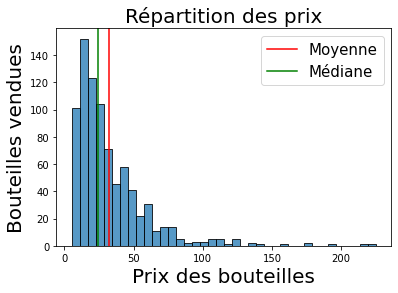

In [50]:
# Graphique montrant la répartition des prix
sns.histplot(data=df_final['price'])
plt.axvline(df_final['price'].mean(), color='red')
plt.axvline(df_final['price'].median(), color='green')
plt.title('Répartition des prix', fontsize=20)
plt.xlabel('Prix des bouteilles', fontsize=20)
plt.ylabel('Bouteilles vendues', fontsize=20)
plt.legend(
    {'Moyenne': df_final['price'].mean(),
    'Médiane': df_final['price'].median()
    }, fontsize=15)

plt.show()

<b>Grace à ce graphique, on s'aperçoit que les premiers prix sont plus fréquemment vendues que les plus élevées</b>

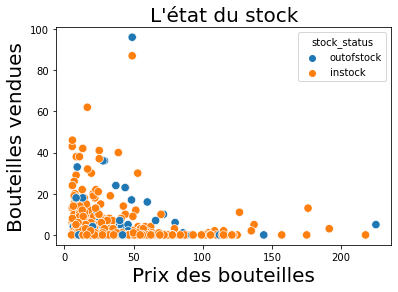

In [51]:
# Représentation en nuage de points
sns.scatterplot(
    data=df_final,
    x='price',
    y='total_sales',
    hue='stock_status',
    hue_order=('outofstock', 'instock'),
    s=70)
plt.xlabel('Prix des bouteilles', fontsize=20)
plt.ylabel('Bouteilles vendues', fontsize=20)
plt.title("L'état du stock", fontsize=20)
plt.show()

<b>Ce graphique permet de voir que la bouteille la plus vendue n'est plus en stock (bouteille à 49 €, le "champagne Gosset Grand Blanc"). La bouteille la plus chère n'est plus en stock également. </b>

# Traitement des outliers

## Première méthode - <a class="anchor" id="section_4_1">Méthode inter-quartile</a>

In [52]:
# Écart inter-quartile
Q1 = df_final['price'].quantile(0.25)
Q3 = df_final['price'].quantile(0.75)
IQR = Q3 - Q1
IQR

27.4

In [53]:
# Calcul de la borne supérieure
# Q3 + 1.5 * (Q3-Q1)
# la variable IQR représentera une partie du calcul (grâce à l'écart réalisé dans la cellule précédente)

borne_superieure = Q3 + 1.5 * IQR
borne_superieure

83.1

In [54]:
# Calcul de la borne inférieure
# Q1 - 1.5 * (Q3-Q1)
# la variable IQR représentera une partie du calcul

borne_inferieure = Q1 - 1.5 * IQR
borne_inferieure

-26.499999999999993

In [55]:
# Création d'un dataframe pour lister les outliers
df_outliers = df_final_ca_sorted.loc[(df_final_ca_sorted['price'] > 83.1) & (df_final_ca_sorted['id_web'].notna()), :]

In [56]:
display(df_outliers.head())

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_name,ca_par_produit
310,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
293,4355,1,126.5,2,instock,12589,11.0,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,1391.5
291,4352,1,225.0,0,outofstock,15940,5.0,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0
478,4904,1,137.0,13,instock,14220,5.0,domaine-des-croix-corton-charlemagne-grand-cru...,685.0
692,5892,1,191.3,10,instock,14983,3.0,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,573.9


In [57]:
# Calcul du CA des outliers
df_outliers['ca_par_produit'].sum()

6970.0

In [58]:
# Proportion des ventes des outliers
(df_outliers['ca_par_produit'].sum() * 100) / df_final['ca_par_produit'].sum()

9.876914094937408

In [59]:
df_outliers.shape

(33, 9)

In [60]:
# Affichage des outliers en triant par le prix en décroissant
display(df_outliers.sort_values('price', ascending=False).head())

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_name,ca_par_produit
291,4352,1,225.0,0,outofstock,15940,5.0,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0
525,5001,1,217.5,20,instock,14581,0.0,david-duband-charmes-chambertin-grand-cru-2014,0.0
692,5892,1,191.3,10,instock,14983,3.0,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,573.9
310,4402,1,176.0,8,instock,3510,13.0,cognac-frapin-vip-xo,2288.0
657,5767,1,175.0,12,instock,15185,0.0,camille-giroud-clos-de-vougeot-2016,0.0


<b>Avec la méthode inter-quartile, on retrouve 33 outliers</b>

## Deuxième méthode - <a class="anchor" id="section_4_2">Méthode z-score</a>

In [61]:
# Calcul du z-score
mean = df_final['price'].mean()
std = df_final['price'].std()

threshold = 2
df_outliers_zscore = []

for i in df_final['price']:
    zscore = (i - mean) / std
    if zscore > threshold:
        df_outliers_zscore.append(i)
print('Les outliers sont ', df_outliers_zscore)

Les outliers sont  [86.1, 144.0, 92.0, 100.0, 88.4, 225.0, 126.5, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 86.8, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0]


<b>Avec la méthode z-score et le threshold à 2, on retrouve 34 outliers</b>

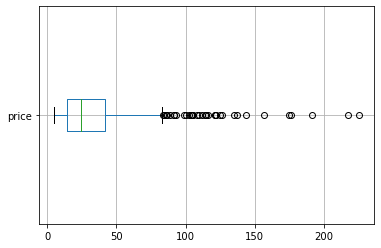

In [62]:
# Représentation avec une boxplot des outliers
df_final.boxplot(column='price', vert=False)
plt.show()